Co-kriging regression is an extension of the well known kriging method to situations where model outputs of differ- ent levels of fidelity (i.e., variations both in computational cost and accuracy) are available to learn a property of interest.

In here, I will try a 2-level co-kriging model with the experimental and DFT bandgaps representing the high-fidelity (expensive and accurate) and low-fidelity (cheap and less trust- worthy) estimates, respectively. N$_e$ data point from experiment, and N_$c$ data point from theory will be used. X$_e$ represent the features of N$_e$, and X$_c$ represent the features of N$_c$.  Here X$_e$ is assumed to be a subset of X$_c$. 

X = (X$_c^1$, X$_c^2$, .... X$_c^n$, X$_e^1$, X$_e^2$, .... X$_e^n$)
y = (y$_c^1$, y$_c^2$, .... y$_c^n$, y$_e^1$, y$_e^2$, .... y$_e^n$). 

where each of the X$_c^i$ and X$_e^i$ is a d-dimensional feature vector that uniquely fingerprints the material compositions in a target chemical space. Furthermore, in a close analogy with kriging, co-kriging also assumes that the value at a point in X is a realization of a Gaus- sian random variable. Therefore, we also have a random field:

Z = (Z$_c$X$_c$, Z$_e$X$_e$) = (Z$_c$X$_c^1$, Z$_c$X$_c^2$, .... Z$_c$X$_c^n$, Z$_e$X$_e^1$, Z$_e$X$_e^2$, .... Z$_e$X$_e^n$)

It is also important to note that the framework discussed here assumes that there is no noise or uncer- tainty in the high-fidelity data (i.e., the experimental bandgaps are being treated as the ground truth).

##### Load packages

In [1]:
import GPy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import time

# Set pandas view options
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

from matminer.datasets.dataset_retrieval import load_dataset
## Generate magpie features
from matminer.featurizers.composition import ElementProperty
from pymatgen import Composition

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import metrics
from sklearn import preprocessing 
import sklearn.gaussian_process as gp
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from pymatgen import MPRester, Composition
mpr = MPRester('68rWEneaZFyIaKh15uKr') # provide your API key here or add it to pymatgen

# Load Data

In [2]:
# load experimental dataset
data = load_dataset('expt_gap')

#clean up the dataframe, some weird formula
data = data[data.formula != 'GaAs0.1P0.9G1128']

#get theory data from MP given compositons
bandgap_info = pickle.load(open('bandgap_by_formula.pkl', 'rb'))

# Combine theory and experiment
bandgap_df = pd.DataFrame([[key]+value for key, value in bandgap_info.items()], 
                          columns=['formula', 'reduced_formula', 'gap theory'])
grouped_final_data = pd.merge(data, bandgap_df, on='formula').drop(columns=['formula']).dropna() 
final_data = grouped_final_data.sort_values(by=['reduced_formula']).reset_index(drop=True)
final_data.head(6)

# featurize the data with magpie features applied on compositions
final_data['composition'] = final_data['reduced_formula'].apply(Composition)
featurizer = ElementProperty.from_preset("magpie")
featurized_data = featurizer.featurize_dataframe(final_data, 'composition')

In [3]:
featurized_data.head(5)

,gap expt,reduced_formula,gap theory,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData minimum NdUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData minimum NfUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData mode NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0.00,Ag(AuS)2,0.0000,"(Ag, Au, S)",16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.600000,10.720000,66.0,32.0650,196.966569,164.901569,113.186268,67.024241,32.0650,388

# Gaussian Process 

1. Split our data into training and test set. 

In [4]:
print('we have {} total data.'.format(featurized_data.shape[0]))

training_df, test_df = train_test_split(featurized_data, test_size=0.2, random_state=42)

print('{} of which will be test data.'.format(test_df.shape[0]))

we have 5216 total data.
1044 of which will be test data.


We will we explores the model performance by varying the number of high- (exp) and low- (theory) fidelity data included in the training set.

In [5]:
## helper function 
def get_features_from_df(df):
    """
    Helper function to get features of dataframe
    """
    magpie_columns = [column for column in df if column.startswith("MagpieData")]
    return df[magpie_columns]

### 1. Use all the DFT data and increase the number of exp data in the training set.  The un-used exp data will be used as valiation set. 

In [6]:
# 1.1 
# Sample various fraction of the total training data 
# -----------------------------------------------------------------
sub_training_df = training_df.sample(n=2000).reset_index(drop=True)

scaler = preprocessing.StandardScaler()
training_X = get_features_from_df(sub_training_df).values.tolist()
training_X = scaler.fit_transform(training_X)

training_theory_y = np.array(sub_training_df[['gap theory']])
training_exp_y = np.array(sub_training_df[['gap expt']])

# split the expt data into training and validation set
exp_train_X, exp_val_X, exp_train_y, exp_val_y = train_test_split(training_X, training_exp_y, 
                                                                  test_size=0.5, random_state=42)

In [7]:
test_X = get_features_from_df(test_df).values.tolist()
test_X = scaler.transform(test_X)
test_exp_y = np.array(test_df[['gap expt']])

In [8]:
# 1.2 MT-GP model
# -----------------------------------------------------------------
start = time.time()
# Define covariance function
N_input = training_X.shape[1]
kx = GPy.kern.RBF(input_dim=N_input, active_dims=range(N_input), ARD=False)
icm = GPy.util.multioutput.ICM(input_dim=N_input, num_outputs=2, kernel=kx,
                               W_rank=2)
icm.rbf.variance.constrain_fixed(1.)

# Define MT-GP model
# col 1 is theory training data, col 2 is expt training data
mtgp = GPy.models.GPCoregionalizedRegression([training_X,        exp_train_X],
                                             [training_theory_y, exp_train_y],
                                             kernel=icm)
mtgp.optimize_restarts(num_restarts=20, verbose=False)

# Build validation dataset
new_xtest = np.hstack((test_X, np.ones((len(test_X), 1))))

In [9]:
test_pred, test_pred_var = mtgp.predict(new_xtest,
                                      Y_metadata={'output_index':(new_xtest[:,N_input:].astype(int))})
test_pred_std = np.sqrt(test_pred_var)

print('Total time: {}'. format(time.time()-start))

Total time: 1508.4086210727692


In [10]:
# measuring errors
rmse = round(np.sqrt(np.mean((test_pred - test_exp_y) ** 2)), 3)
mae = round(metrics.mean_absolute_error(test_pred, test_exp_y), 3)
# mean of the predicted standard deviation (MPSd)
MPSd = round(np.mean(test_pred_std),3)

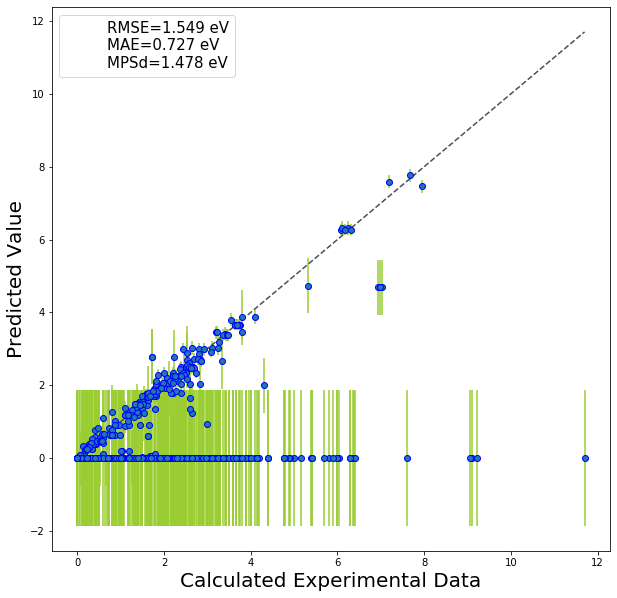

In [11]:
plt.figure(figsize=(10,10))
plt.errorbar(test_exp_y,  test_pred,  yerr=test_pred_std, 
             linestyle="None", marker='o', mec='blue',ecolor='yellowgreen')
plt.xlabel('Calculated')
plt.ylabel('Predicted')
plt.plot([np.min(test_pred), np.max(test_exp_y)], 
         [np.min(test_pred), np.max(test_exp_y)], 
         ls="--", c=".3")

# Create empty plot with blank marker containing the extra label
plt.plot([], [], ' ', label='RMSE={} eV\nMAE={} eV\nMPSd={} eV'.format(rmse, mae, MPSd))
plt.legend(fontsize=15)
plt.xlabel('Calculated Experimental Data',fontsize=20)
plt.ylabel('Predicted Value',fontsize=20)
plt.show()